In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import sys
import os
import numpy as np
import geopandas as gpd
from glob import glob
import statsmodels.api as sm
plt.style.reload_library()
plt.style.use('EuroSAFs_pub')

In [3]:
sys.path.insert(1,'../../scripts/optimization/')

In [4]:
import plant_optimization as pop
from plant_optimization.notebook_tools import *

In [5]:
europe_grid = gpd.read_file('../../data/Countries_WGS84/processed/Europe_Evaluation_Grid.shp')
europe_grid.rename(columns={'grid_lat':'lat','grid_lon':'lon'},inplace=True)
europe_grid['sea_node'] = europe_grid.sea_node.astype(bool)
europe_borders = gpd.read_file('../../data/Countries_WGS84/processed/Europe_WGS84.shp')

In [6]:
sensitivity_results_path = os.path.join('../../results/plant_optimization/32af5fd_sensitivity/onshore') # Points to the location of the results csv files
results_path = os.path.join('../../results/plant_optimization/8c646f4_2020/onshore') # Points to the location of the results csv files

In [7]:
specs = pd.read_excel('../../data/plant_assumptions.xlsx',sheet_name='data',index_col=0)
specs_names = specs.index

# Load Results

In [8]:
# Load all sensitivity results files into a single dataframe
sensitivity = pd.DataFrame()
for file_glob in glob(f'{sensitivity_results_path}/sensitivity*.csv'): 
    sensitivity = sensitivity.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    
# Load all optimization results (with 2020 parameters) into a single dataframe
countries = europe_grid.country.unique()
results_2020_raw = pd.DataFrame()
for country in countries:
    df = pd.DataFrame()
    for file_glob in glob(f'{results_path}/{country}*.csv'): 
        df = df.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    df['country'] = country
    results_2020_raw = results_2020_raw.append(df) 
results_2020 = results_2020_raw.drop(columns=specs_names)

# Merge the above two dataframes
# combined = sensitivity.merge(results_2020,on=['lat','lon','shore_designation'],how='left',suffixes=('_sensi','_2020'))
# NOTE: THE FOLLOWING LINE SHOULD BE USED INSTEAD OF THE ONE ABOVE ONCE THE SENSITIVITY RESULTS INCLUDE THE COUNTRY NAME
combined = gpd.GeoDataFrame(sensitivity.merge(results_2020,on=['lat','lon','country','shore_designation'],how='left',suffixes=('_sensi','_2020')))
combined['sea_node'] = combined.apply(lambda x: True if x.shore_designation=='offshore' else False, axis=1)
combined_gdf = gpd.GeoDataFrame(combined.merge(europe_grid,on=['lat','lon','country','sea_node'],how='left'))

# Normalize the LCOF found n the sensitivty analysis relative to that found for the 2020 parameters
combined_gdf['LCOF_liter_norm'] = combined_gdf.LCOF_liter_sensi/combined_gdf.LCOF_liter_2020
combined_gdf['wind_CAPEX'] = combined_gdf.apply(lambda x: x[f'wind_{x.wind_class_sensi}_CAPEX']/specs.at[f'wind_{x.wind_class_sensi}_CAPEX','value_2020'],axis=1)
combined_gdf['wind_OPEX'] = combined_gdf.apply(lambda x: x[f'wind_{x.wind_class_sensi}_OPEX']/specs.at[f'wind_{x.wind_class_sensi}_OPEX','value_2020'],axis=1)
combined_gdf.drop(columns=['wind_lo_CAPEX','wind_lo_OPEX','wind_mid_CAPEX','wind_mid_OPEX','wind_hi_CAPEX','wind_hi_OPEX','wind_monopole_CAPEX','wind_monopole_OPEX','wind_jacket_CAPEX','wind_jacket_OPEX','wind_floating_CAPEX','wind_floating_OPEX'],
                  inplace=True)

# Remove outliers
z_score_filter = 3
prev_len = len(combined_gdf)
mask = abs(combined_gdf.LCOF_liter_norm.mean()-combined_gdf.LCOF_liter_norm)<z_score_filter*combined_gdf.LCOF_liter_norm.std()
combined_gdf = combined_gdf.loc[mask]
print(f'{prev_len-len(combined_gdf)} outlier entries were dropped.')

3 outlier entries were dropped.


In [9]:
both_cols = [x for x in results_2020_raw.columns if x in sensitivity.columns and x in specs_names]
for col in both_cols:
    print(col,'2020:',f'{results_2020_raw[col].mean():,.3f}','sensi:',f'{sensitivity[col].mean():,.3f}')

CO2_CAPEX 2020: 730.000 sensi: 732.507
CO2_OPEX 2020: 0.040 sensi: 0.040
CO2_el_efficiency 2020: 1.600 sensi: 1.600
CO2_lifetime 2020: 12.000 sensi: 12.035
CO2_max_capacity 2020: 100,000.000 sensi: 100,000.000
CO2_min_capacity 2020: 0.000 sensi: 0.000
CO2_th_efficiency 2020: 0.400 sensi: 0.400
CO2stor_CAPEX 2020: 1,500.000 sensi: 1,501.834
CO2stor_OPEX 2020: 0.025 sensi: 0.025
CO2stor_lifetime 2020: 30.000 sensi: 30.000
CO2stor_max_capacity 2020: 10,000,000.000 sensi: 10,000,000.000
CO2stor_min_capacity 2020: 0.000 sensi: 0.000
H2stor_CAPEX 2020: 21.496 sensi: 21.453
H2stor_OPEX 2020: 0.010 sensi: 0.010
H2stor_lifetime 2020: 30.000 sensi: 30.000
H2stor_max_capacity 2020: 10,000,000.000 sensi: 10,000,000.000
H2stor_min_capacity 2020: 0.000 sensi: 0.000
H2tL_CAPEX 2020: 799.000 sensi: 797.033
H2tL_OPEX 2020: 0.025 sensi: 0.025
H2tL_baseload 2020: 0.800 sensi: 0.799
H2tL_chem_efficiency 2020: 0.650 sensi: 0.649
H2tL_el_efficiency 2020: 22.062 sensi: 22.062
H2tL_heat_output 2020: 0.326 sen

# LCOF Distribution

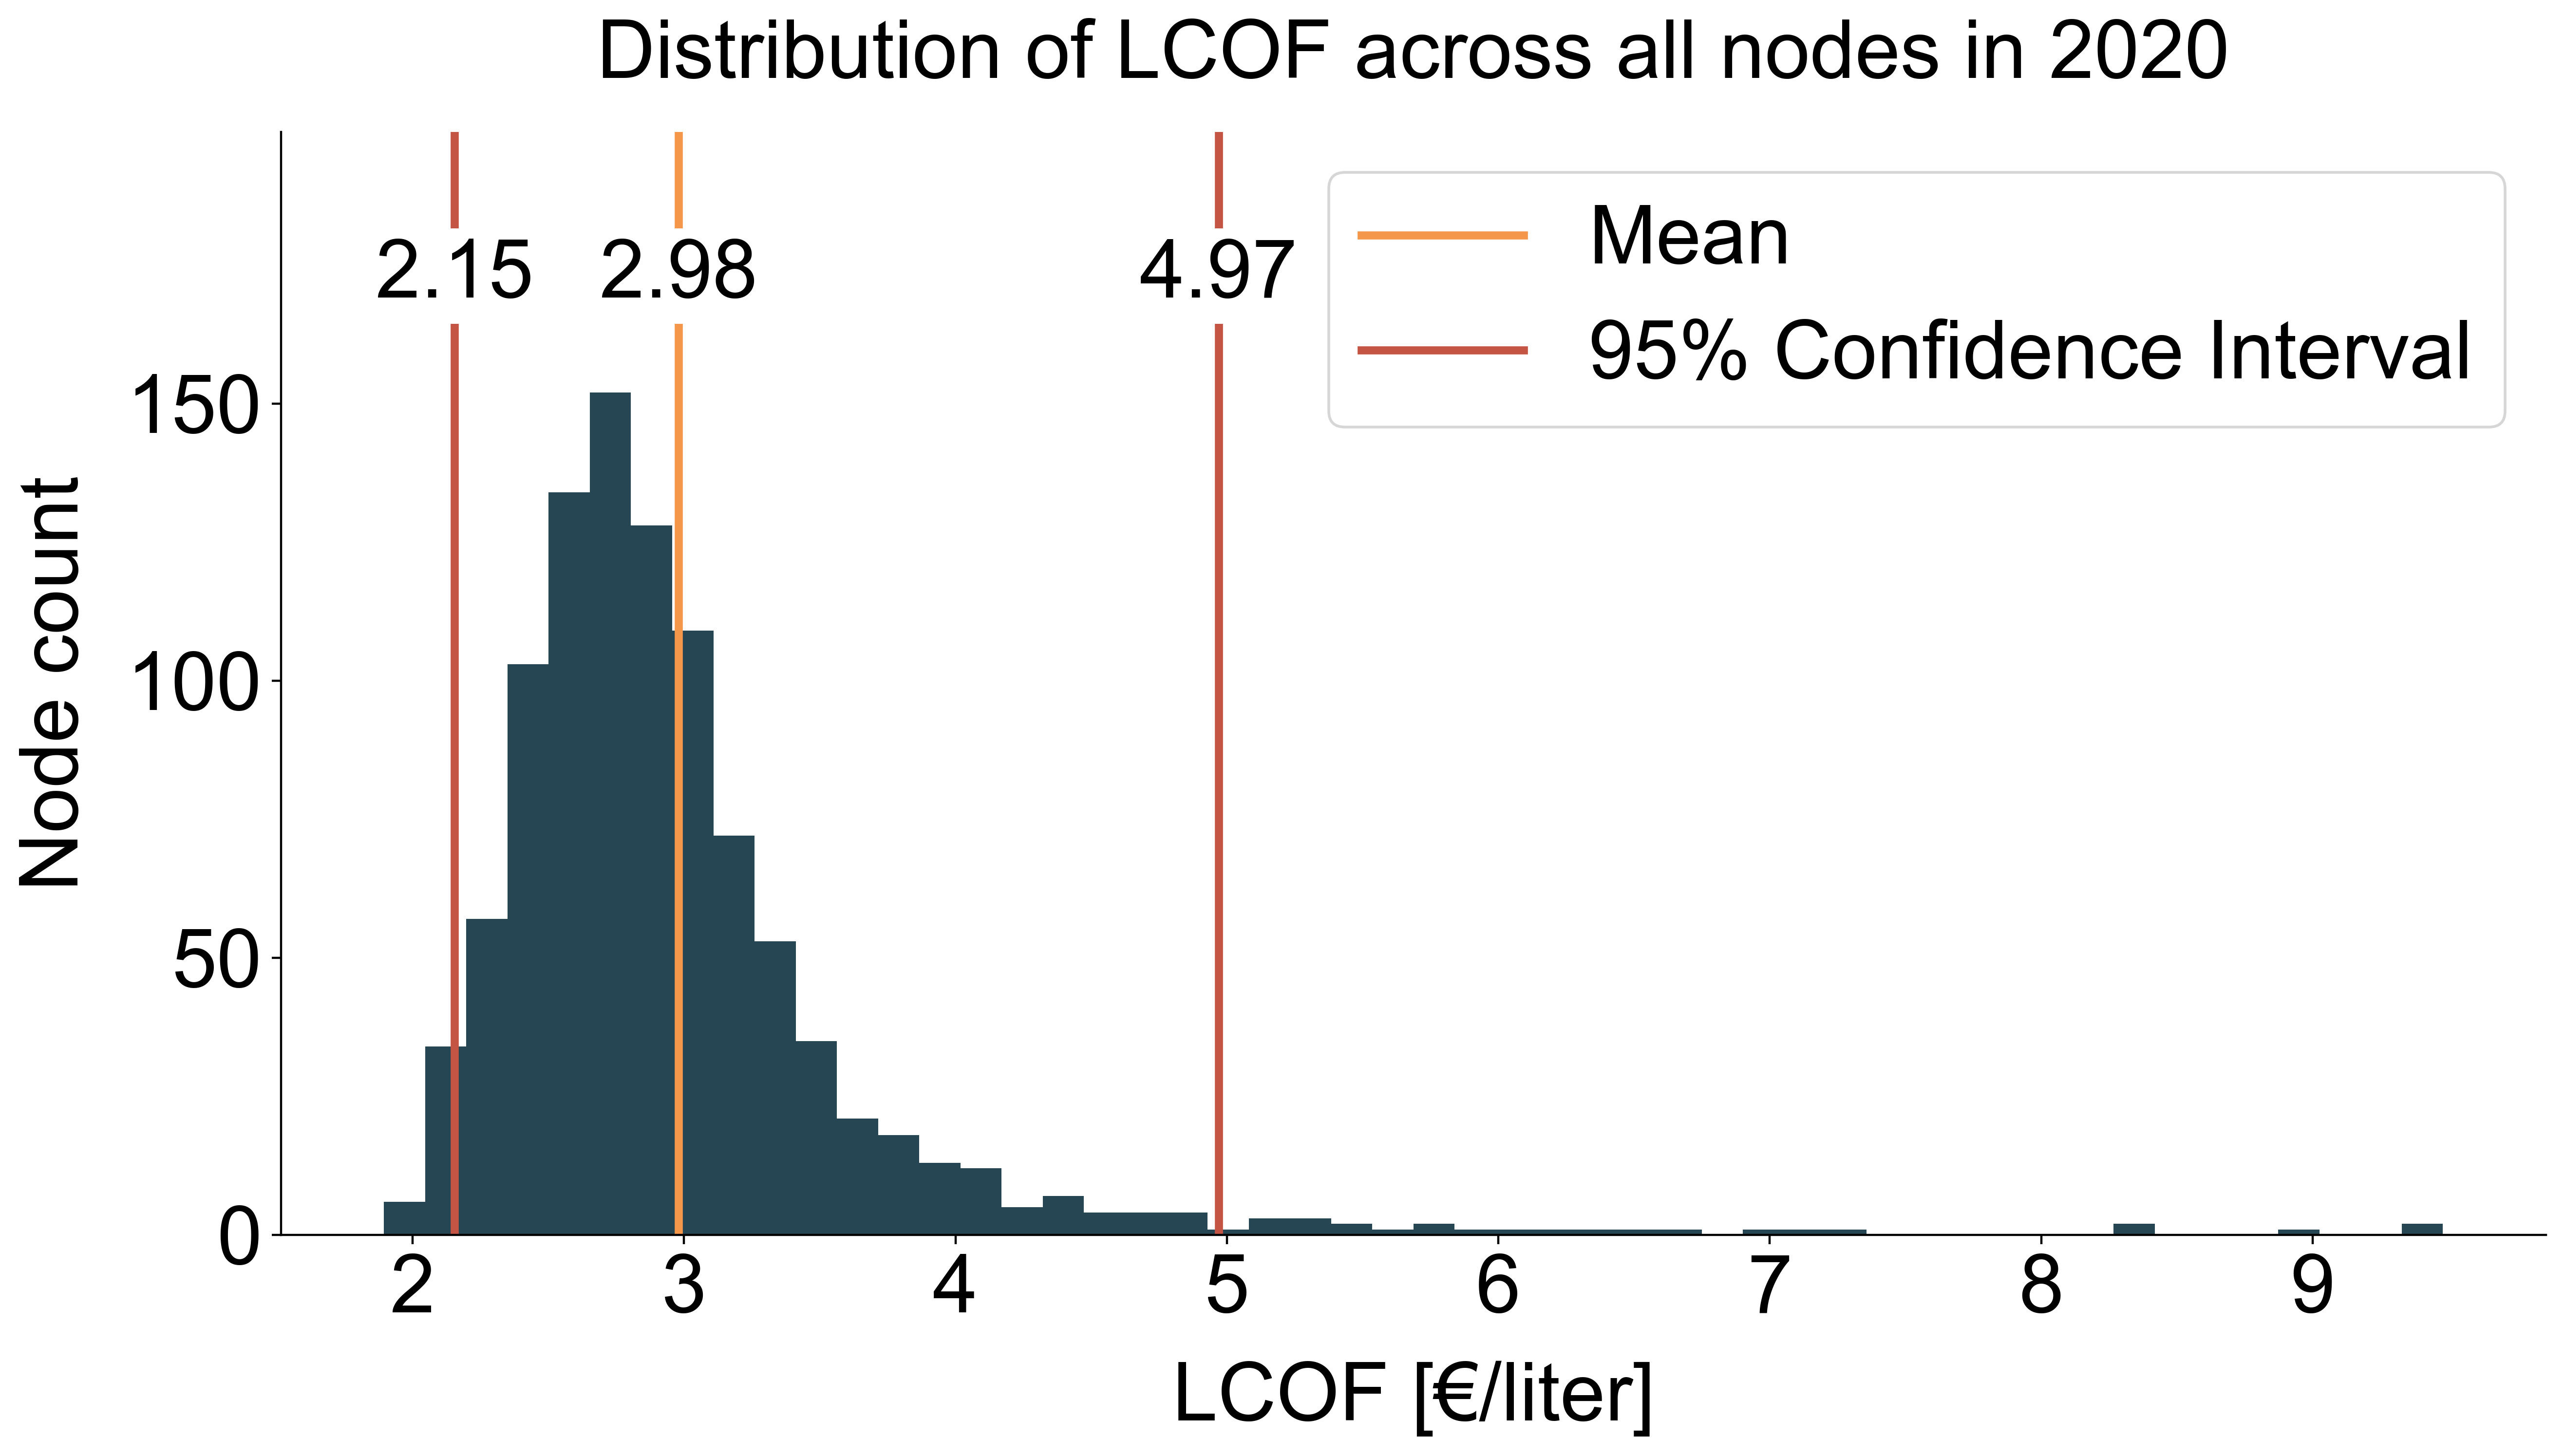

In [33]:
figsize=(15,7.5)
ymax = 199
plt.figure(figsize=figsize)
fontsize=figsize[0]*2
ax = combined_gdf.LCOF_liter_sensi.hist(bins=50)
ax.axvline(combined_gdf.LCOF_liter_sensi.mean(), linewidth=3,c='C1',label='Mean')
ax.text(combined_gdf.LCOF_liter_sensi.mean(),ymax*0.85, round(combined_gdf.LCOF_liter_sensi.mean(),2), fontsize=fontsize, horizontalalignment='center',
        bbox={'facecolor':'white','edgecolor':(0,0,0,0)})
ax.axvline(combined_gdf.LCOF_liter_sensi.quantile(0.025),linewidth=3,c='C2',label='95% Confidence Interval')
ax.text(combined_gdf.LCOF_liter_sensi.quantile(0.025),ymax*0.85, round(combined_gdf.LCOF_liter_sensi.quantile(0.025),2), fontsize=fontsize, horizontalalignment='center',
        bbox={'facecolor':'white','edgecolor':(0,0,0,0)})
ax.axvline(combined_gdf.LCOF_liter_sensi.quantile(0.975),linewidth=3,c='C2',)
ax.text(combined_gdf.LCOF_liter_sensi.quantile(0.975),ymax*0.85, round(combined_gdf.LCOF_liter_sensi.quantile(0.975),2), fontsize=fontsize, horizontalalignment='center',
        bbox={'facecolor':'white','edgecolor':(0,0,0,0)})
ax.set_xlabel('LCOF [€/liter]',fontsize=fontsize)
ax.set_ylabel('Node count',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(b=None)
ax.set_ylim(0,ymax)
ax.set_title('Distribution of LCOF across all nodes in 2020',fontsize=fontsize,pad=20)
ax.legend(fontsize=fontsize);

plt.savefig('../../gfx/LCOF_distribution.png',dpi=400)

<font color=red> The above plot should probably be included in the appendix and will have to be accompanied by a very throough explanation.

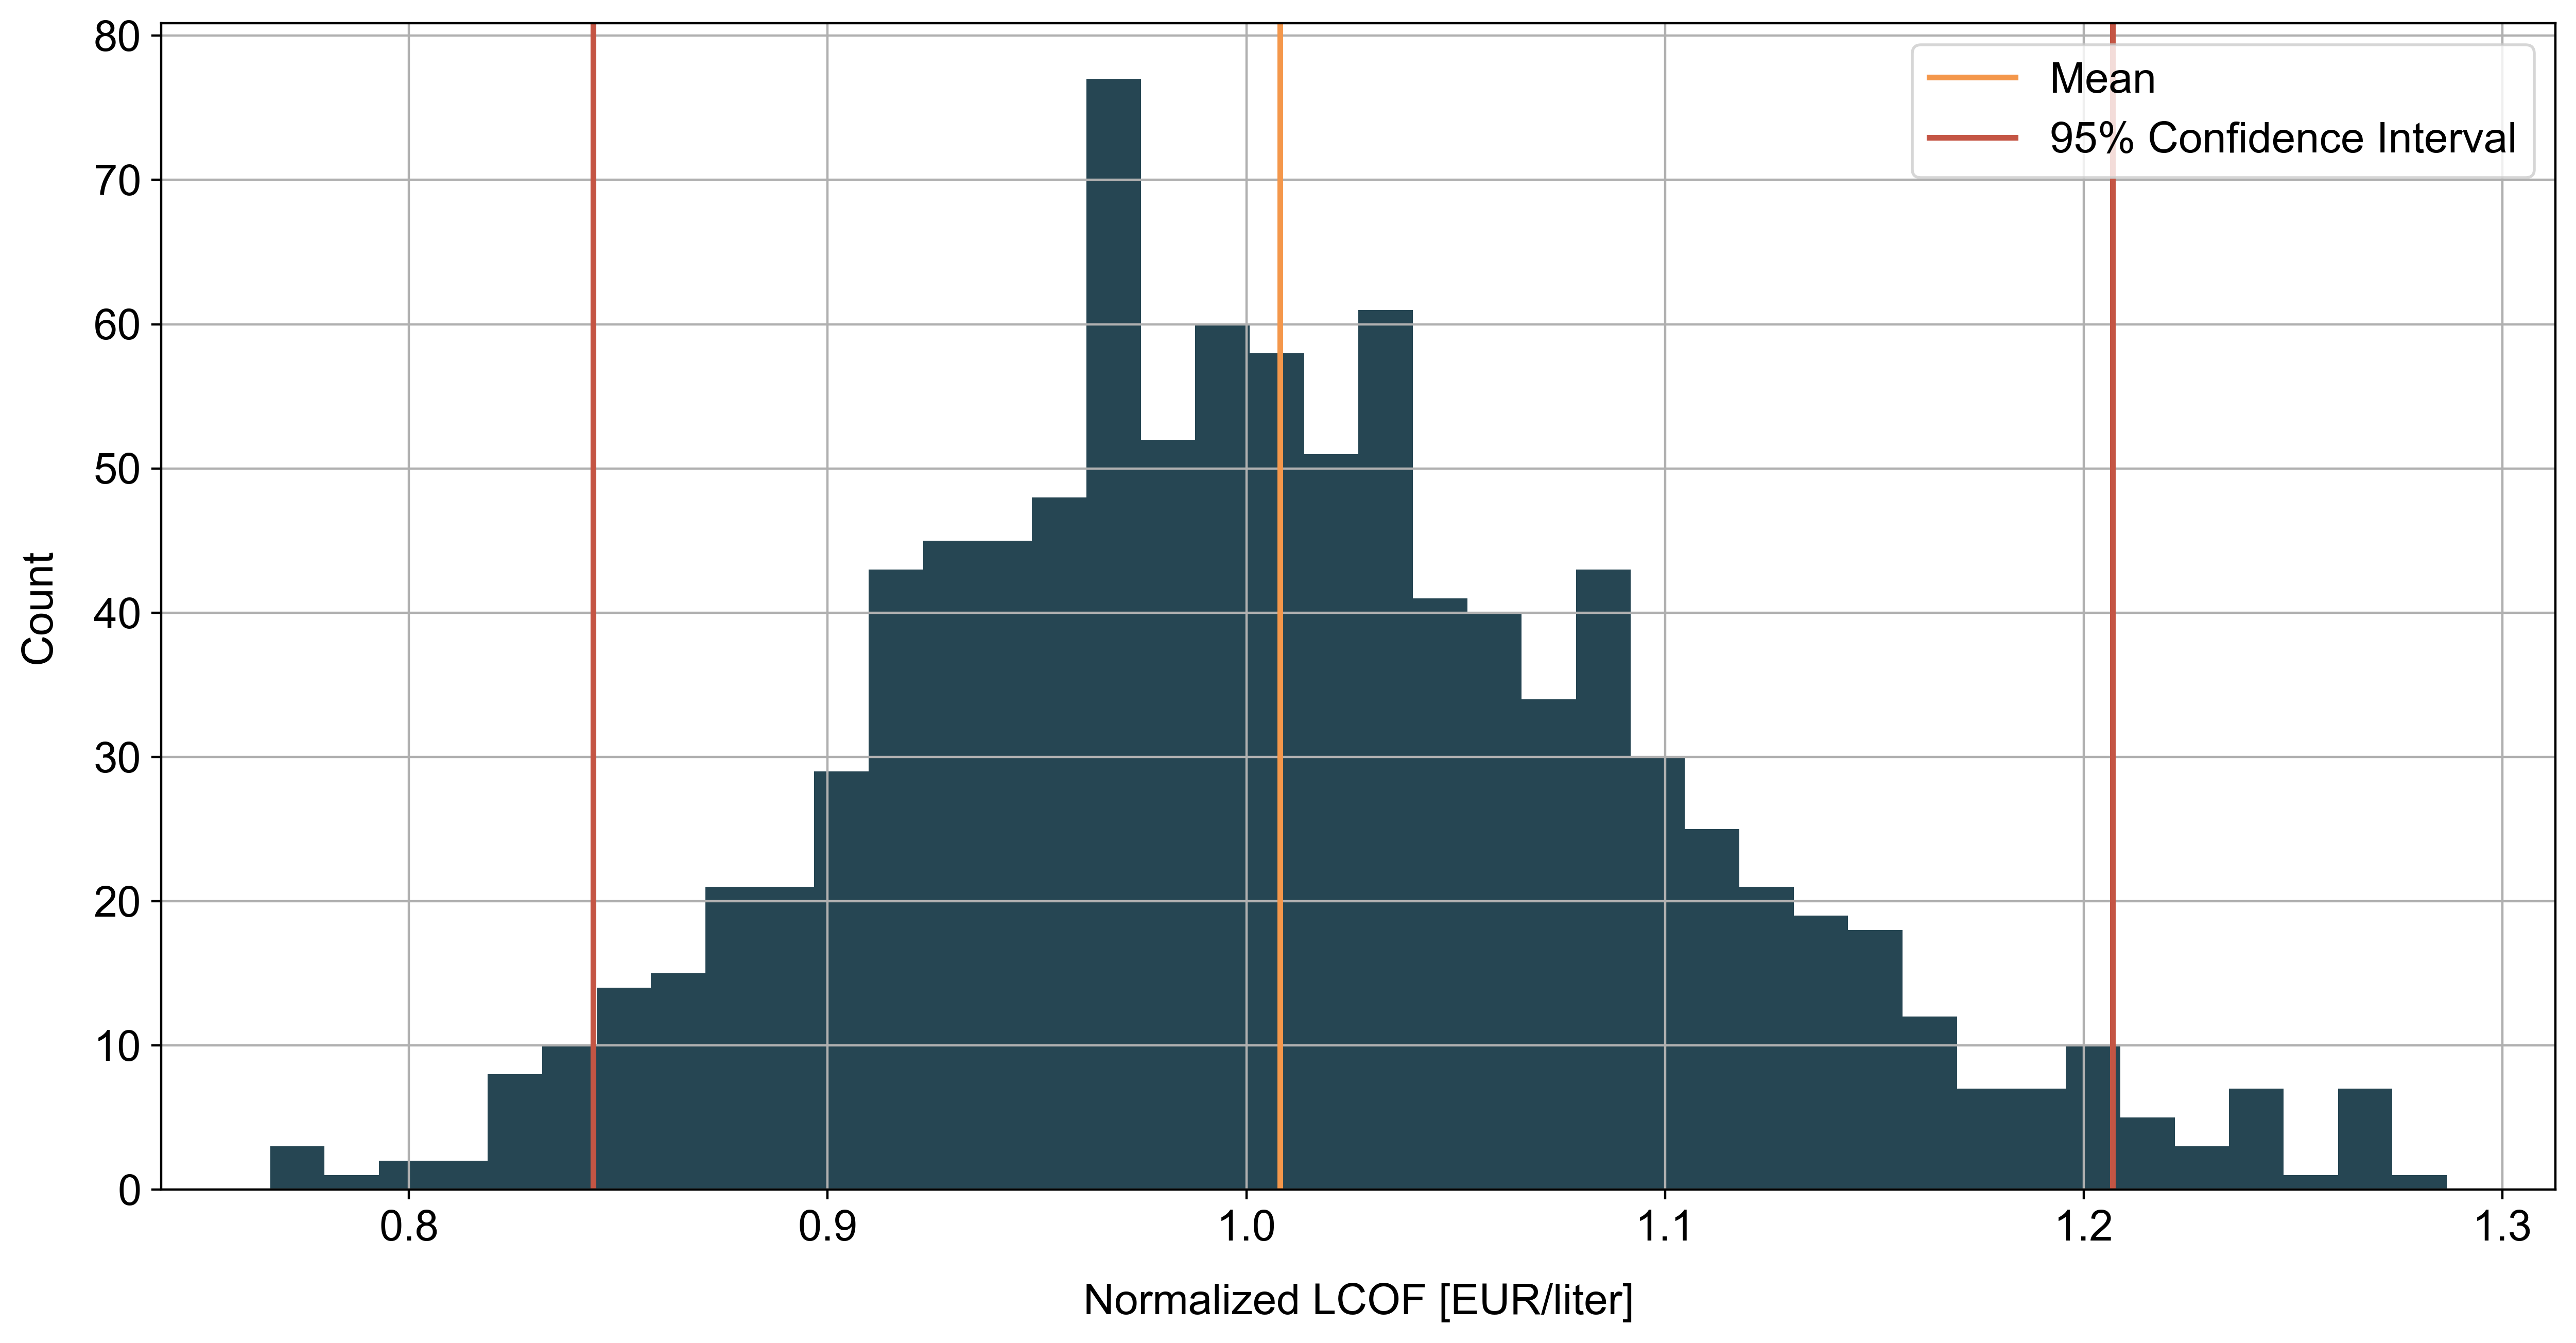

In [13]:
plt.figure(figsize=(15,7.5))
ax = combined_gdf.LCOF_liter_norm.hist(bins=40)
ax.axvline(combined_gdf.LCOF_liter_norm.mean(),c='C1',label='Mean')
ax.axvline(combined_gdf.LCOF_liter_norm.quantile(0.025),c='C2',label='95% Confidence Interval')
ax.axvline(combined_gdf.LCOF_liter_norm.quantile(0.975),c='C2',)
ax.set_xlabel('Normalized LCOF [EUR/liter]')
ax.set_ylabel('Count')
ax.legend();

# Identify correlations

In [14]:
eval_params = [x for x in combined_gdf.columns if x in specs_names or x in ['wind_CAPEX','wind_OPEX']]
eval_params = [x for x in eval_params if combined_gdf[x].max()!=combined_gdf[x].min()]
eval_params = [x for x in eval_params if combined_gdf[x].isna().sum()==0]
ols_reg = pd.DataFrame()
n_digits = 2
for eval_param in eval_params:
    X = combined_gdf[eval_param]
    Y = combined_gdf.LCOF_liter_norm
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    ols_reg = ols_reg.append({
        'Parameter':eval_param,
        'Intercept':results.params.const,
        'Intercept 95% C.I.':f'[{round(results.conf_int().loc["const"][0],n_digits):+.2f},{round(results.conf_int().loc["const"][1],n_digits):+.2f}]',
        'Slope':results.params[eval_param],
        'Slope 95% C.I.':f'[{round(results.conf_int().loc[eval_param][0],n_digits):+.2f},{round(results.conf_int().loc[eval_param][1],n_digits):+.2f}]',
        'R-Squared':results.rsquared,
        
#         'rsquared_adj':results.rsquared_adj
    },ignore_index=True)
ols_reg = ols_reg[['Parameter','Slope','Slope 95% C.I.','Intercept','Intercept 95% C.I.','R-Squared']]

In [15]:
ols_reg.sort_values('R-Squared',ascending=False).reset_index(drop=True).head(5)

,Parameter,Slope,Slope 95% C.I.,Intercept,Intercept 95% C.I.,R-Squared
0,H2tL_chem_efficiency,-1.579817,"[-1.67,-1.49]",2.034238,"[+1.98,+2.09]",0.563053
1,electrolyzer_efficiency,-0.987671,"[-1.11,-0.86]",1.601483,"[+1.53,+1.68]",0.190278
2,wind_CAPEX,0.390773,"[+0.31,+0.47]",0.616848,"[+0.53,+0.70]",0.080778
3,discount_rate,5.488395,"[+3.87,+7.10]",0.733692,"[+0.65,+0.81]",0.042794
4,electrolyzer_CAPEX,0.000190,"[+0.00,+0.00]",0.801955,"[+0.72,+0.88]",0.023533


In [16]:
ols_reg.sort_values('R-Squared',ascending=False).reset_index(drop=True).to_latex('../../latex/sensitivity_parameters_export.tex',index=False)
ols_reg.sort_values('R-Squared',ascending=False).reset_index(drop=True).to_csv('../../latex/sensitivity_parameters_export.csv',index=False)

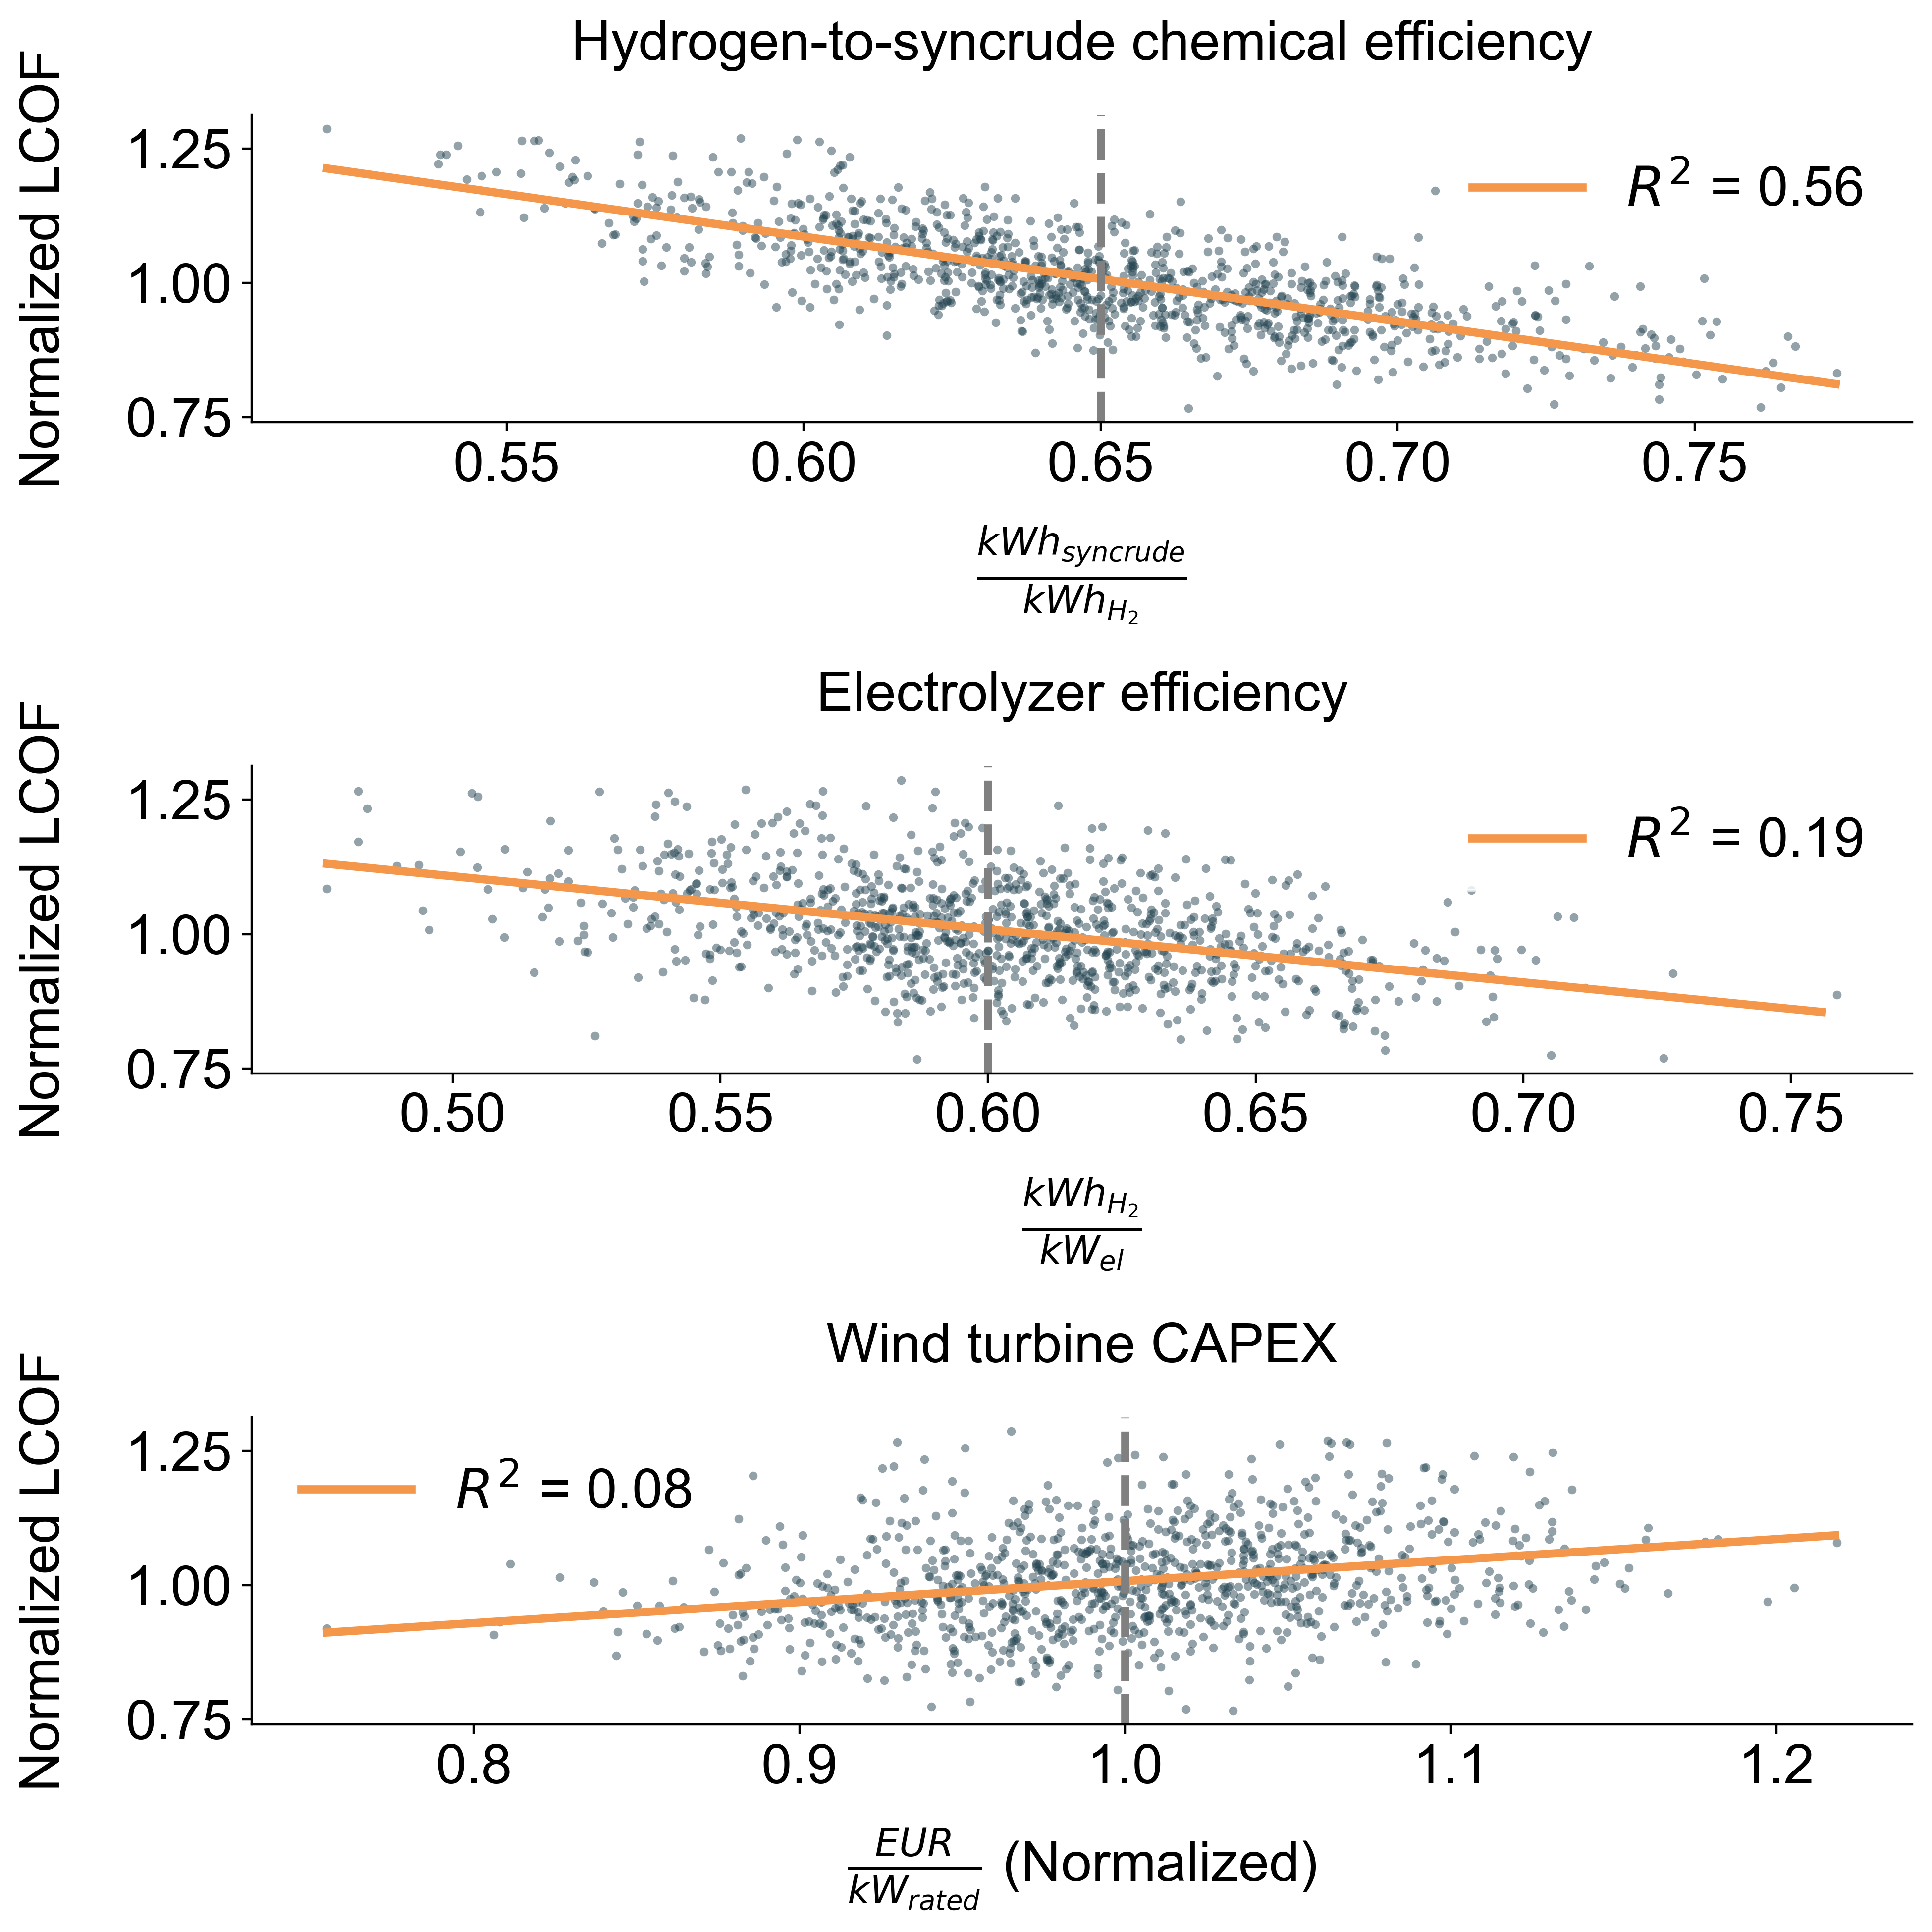

In [37]:
figsize=(10,10)
fontsize=figsize[0]*2
params_count = 3
ncols=1
df = combined_gdf.copy()
ols_reg_slice = ols_reg.loc[ols_reg.Parameter!='discount_rate'].sort_values('R-Squared',ascending=False).iloc[:params_count].reset_index(drop=True).copy()

cmap = 'RdYlGn_r'

titles = {
    'H2tL_chem_efficiency':'Hydrogen-to-syncrude chemical efficiency',
    'electrolyzer_efficiency': 'Electrolyzer efficiency',
    'wind_CAPEX': 'Wind turbine CAPEX',
    'electrolyzer_CAPEX': 'Electrolyzer CAPEX'
}
units_map = {
    'H2tL_chem_efficiency':r'$\frac{kWh_{syncrude}}{kWh_{H_{2}}}$',
    'electrolyzer_efficiency':r'$\frac{kWh_{H_{2}}}{kW_{el}}$',
    'wind_CAPEX':r'$\frac{EUR}{kW_{rated}}$',
    
}
if ncols == None:
    ncols = int(np.ceil(np.sqrt(params_count)))
nrows = int(np.ceil(params_count/ncols))    
fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
axes = np.reshape(axes,(1,nrows*ncols))[0]
for idx,row in ols_reg_slice.iterrows():
    axes[idx].scatter(df[row.Parameter],df.LCOF_liter_norm, s=10, alpha=0.5, lw=0)#, cmap=cmap, vmin=2, vmax=4, c=df.LCOF_liter_2020)
    maxx = df[row.Parameter].max()
    minx = df[row.Parameter].min()
    x = np.arange(minx,maxx,round((maxx-minx)/100,5))
    y = row.Slope*x + row.Intercept
    axes[idx].plot(x,y,linewidth=3,color='C1',label=fr'$R^{2}$ = {row["R-Squared"]:.2f}')
    if row.Parameter not in ['wind_CAPEX','wind_OPEX']:
        chosen_val = specs.at[row.Parameter,'value_2020']
        units = units_map[row.Parameter]
    else:
        chosen_val = 1
        units = units_map[row.Parameter] + ' (Normalized)'
    axes[idx].axvline(chosen_val,linewidth=3,linestyle='--',c='grey')
    axes[idx].set_xlabel(units,fontsize=fontsize)
    axes[idx].set_title(titles[row.Parameter],fontsize=fontsize)
    axes[idx].tick_params(labelsize=fontsize)
    axes[idx].legend(fontsize=fontsize,edgecolor=(1,1,1,0.5),facecolor=(1, 1, 1, 0.5))#,loc='upper right')
    if idx in [x*ncols for x in range(nrows)]:
        axes[idx].set_ylabel('Normalized LCOF',labelpad=20,fontsize=fontsize)
    
    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)
plt.subplots_adjust(hspace=0.9,wspace=0.2)
plt.tight_layout()
plt.savefig('../../gfx/highest_sensitivities.png',dpi=400,bbox_inches='tight')

<font color=red> Reduce number of paramters displayed to 3. Include all parameter R-squared values and linear fit parameters with a 95% C.I. in a table (potentially in the appendix). If the 95% CI range of the slope spans zero (meaning it can either be positive or negative), this would indicate that the LCOF is not really correlated with the parameter.

# Normalize 

In [21]:
eval_params = [x for x in combined_gdf.columns if x in specs_names or x in ['wind_CAPEX','wind_OPEX']]
eval_params = [x for x in eval_params if combined_gdf[x].max()!=combined_gdf[x].min()]
eval_params = [x for x in eval_params if combined_gdf[x].isna().sum()==0]
ols_reg_norm = pd.DataFrame()
for eval_param in eval_params:
    X = combined_gdf[eval_param].copy()
    if eval_param not in ['wind_CAPEX','wind_OPEX']:
        X /= specs.at[eval_param,'value_2020']
    X = sm.add_constant(X)
    Y = combined_gdf.LCOF_liter_norm.copy()
    model = sm.OLS(Y,X)
    results = model.fit()
    ols_reg_norm = ols_reg_norm.append({'parameter':eval_param,'const':results.params.const,'slope':results.params[eval_param],'rsquared':results.rsquared,'rsquared_adj':results.rsquared_adj},ignore_index=True)
ols_reg_norm = ols_reg_norm[['parameter','slope','const','rsquared','rsquared_adj']]

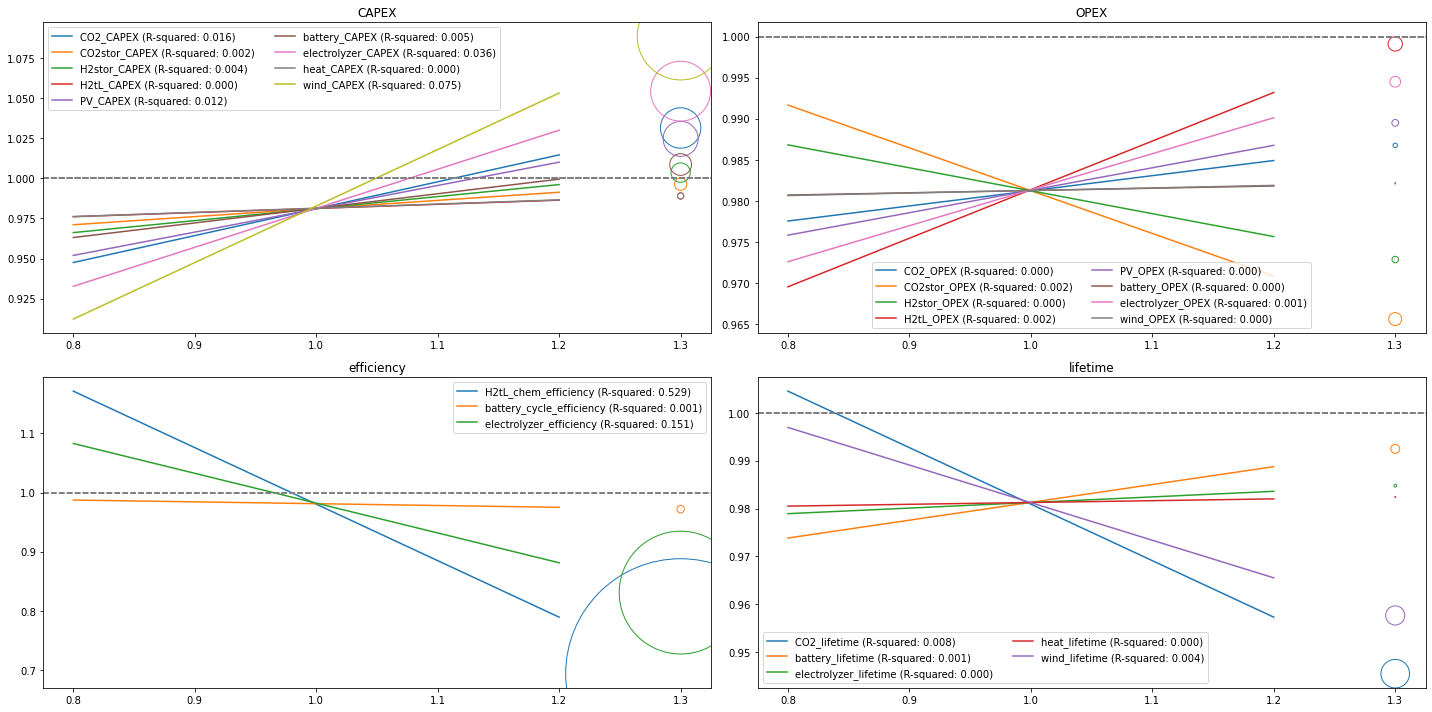

In [22]:
figsize=(20,10)
param_groups = {'CAPEX':[],'OPEX':[],'efficiency':[],'lifetime':[]}
ncols=None
xspan = 0.3
for key in param_groups.keys():
    param_groups[key] = [x for x in ols_reg_norm.parameter if key in x]
    
if ncols == None:
    ncols = int(np.ceil(np.sqrt(len(param_groups))))
nrows = int(np.ceil(len(param_groups)/ncols))  

fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
axes = np.reshape(axes,(1,len(param_groups)))[0]
for i,(param_group,parameters) in enumerate(param_groups.items()):
    max_rsquared = ols_reg_norm.loc[ols_reg_norm.parameter.isin(parameters),'rsquared'].sort_values(ascending=False).iloc[0]
    for j,parameter in enumerate(parameters):
#         if parameter=='wind_CAPEX' or parameter=='wind_OPEX':
#             normed_slope = ols_reg_norm.loc[ols_reg_norm.parameter==parameter,'slope'].item()
#         else:        
#             normed_slope = ols_reg_norm.loc[ols_reg_norm.parameter==parameter,'slope'].item()*specs.at[parameter,'value_2020']
        normed_slope = ols_reg_norm.loc[ols_reg_norm.parameter==parameter,'slope'].item()
        rsquared = ols_reg_norm.loc[ols_reg_norm.parameter==parameter,'rsquared'].item()
#         x = np.arange(1-xspan*rsquared/max_rsquared,1+xspan*rsquared/max_rsquared+.001,0.001)
        x = np.arange(0.8,1.3,0.1)
        y = normed_slope*x + ols_reg_norm.loc[ols_reg_norm.parameter==parameter,'const'].item()
        rsquared_markx = np.array([1.3])
        rsquared_marky = normed_slope*rsquared_markx + ols_reg_norm.loc[ols_reg_norm.parameter==parameter,'const'].item()
        dash_bins = []
        axes[i].plot(x,y,color=f'C{j}',label=f'{parameter} (R-squared: {rsquared:.3f})')
        axes[i].axhline(y=1,linestyle='--',color='grey')
        axes[i].scatter(rsquared_markx,rsquared_marky,color=f'C{j}',facecolors='none',s=rsquared*1e5)
    axes[i].legend(ncol=2 if len(parameters)>3 else 1)
    axes[i].set_title(param_group)
plt.tight_layout()
# plt.savefig('../../gfx/parameter_sensitivity.png',dpi=400)

<font color=red> The above plot should not be incldued in the paper. The uncertainty of the R-squared values is so too high for probably all parameters except H2tL efficiency & electrolyzer efficiency.

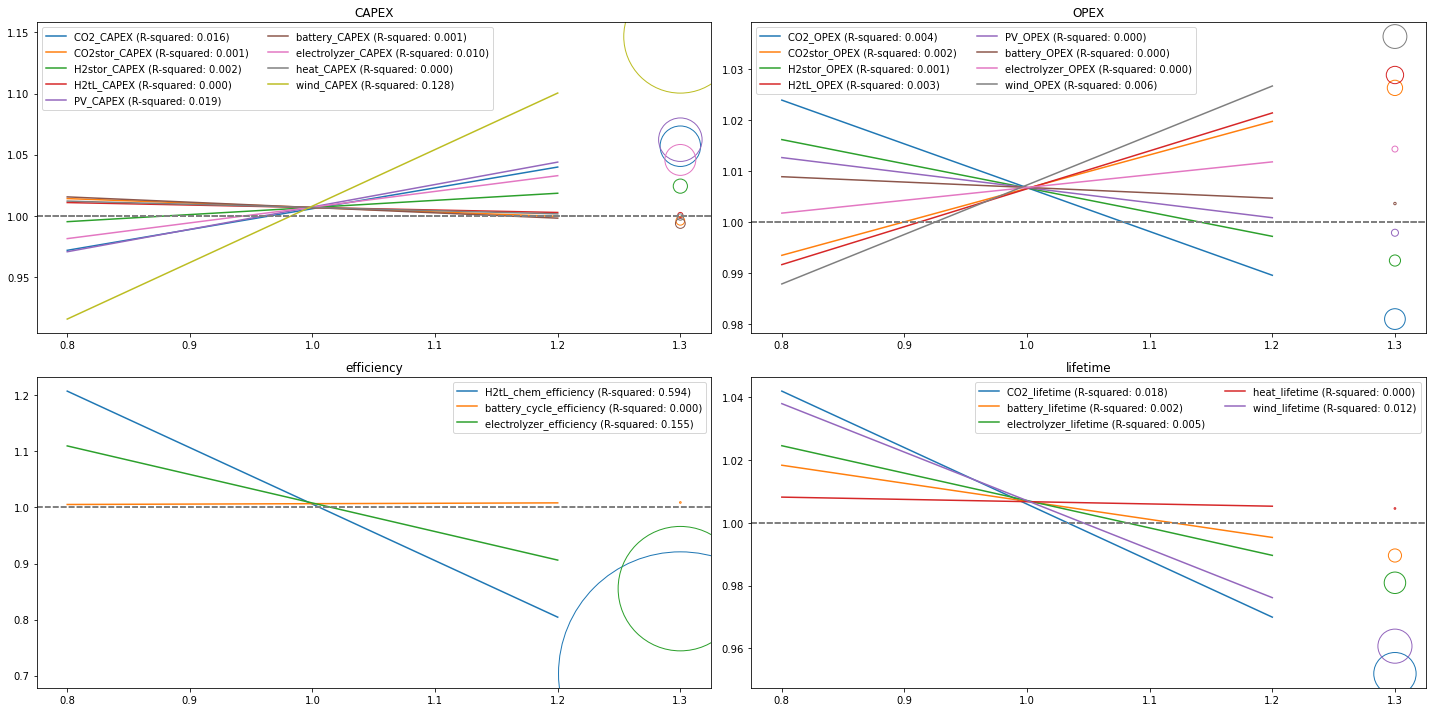

In [59]:
figsize=(20,10)
param_groups = {'CAPEX':[],'OPEX':[],'efficiency':[],'lifetime':[]}
ncols=None
xspan = 0.3
for key in param_groups.keys():
    param_groups[key] = [x for x in ols_reg_norm.parameter if key in x]
    
if ncols == None:
    ncols = int(np.ceil(np.sqrt(len(param_groups))))
nrows = int(np.ceil(len(param_groups)/ncols))  

fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
axes = np.reshape(axes,(1,len(param_groups)))[0]
for i,(param_group,parameters) in enumerate(param_groups.items()):
    max_rsquared = ols_reg_norm.loc[ols_reg_norm.parameter.isin(parameters),'rsquared'].sort_values(ascending=False).iloc[0]
    for j,parameter in enumerate(parameters):
#         if parameter=='wind_CAPEX' or parameter=='wind_OPEX':
#             normed_slope = ols_reg_norm.loc[ols_reg_norm.parameter==parameter,'slope'].item()
#         else:        
#             normed_slope = ols_reg_norm.loc[ols_reg_norm.parameter==parameter,'slope'].item()*specs.at[parameter,'value_2020']
        normed_slope = ols_reg_norm.loc[ols_reg_norm.parameter==parameter,'slope'].item()
        rsquared = ols_reg_norm.loc[ols_reg_norm.parameter==parameter,'rsquared'].item()
#         x = np.arange(1-xspan*rsquared/max_rsquared,1+xspan*rsquared/max_rsquared+.001,0.001)
        x = np.arange(0.8,1.3,0.1)
        y = normed_slope*x + ols_reg_norm.loc[ols_reg_norm.parameter==parameter,'const'].item()
        rsquared_markx = np.array([1.3])
        rsquared_marky = normed_slope*rsquared_markx + ols_reg_norm.loc[ols_reg_norm.parameter==parameter,'const'].item()
        dash_bins = []
        axes[i].plot(x,y,color=f'C{j}',label=f'{parameter} (R-squared: {rsquared:.3f})')
        axes[i].axhline(y=1,linestyle='--',color='grey')
        axes[i].scatter(rsquared_markx,rsquared_marky,color=f'C{j}',facecolors='none',s=rsquared*1e5)
    axes[i].legend(ncol=2 if len(parameters)>3 else 1)
    axes[i].set_title(param_group)
plt.tight_layout()
# plt.savefig('../../gfx/parameter_sensitivity.png',dpi=400)